# Tutorial on Ridge and Lasso Regression 
Reference:  
* AARSHAY JAIN - A Complete Tutorial on Ridge and Lasso Regression in Python
* https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/

## Overview
Ridge and Lasso Regression are regularization techniques generally used for creating parsimonious models (Occum's Razor) in presence of a large number of features. The main goal is to combat tendency of models to overfit and balance the statistical-computational tradeoffs that are ubiquitous in the high-dimensional statistics era. 

* Ridge Regression
    - L2-regularization 
    - Obj = Loss Function + $\alpha\|\beta\|_2$
* Lasso Regression
    - L1-regularization
    - Obj = Loss Function + $\alpha\|\beta\|_1$

## Why penalize the magnitude of coefficients?

Consider the following simulation of a sine curve

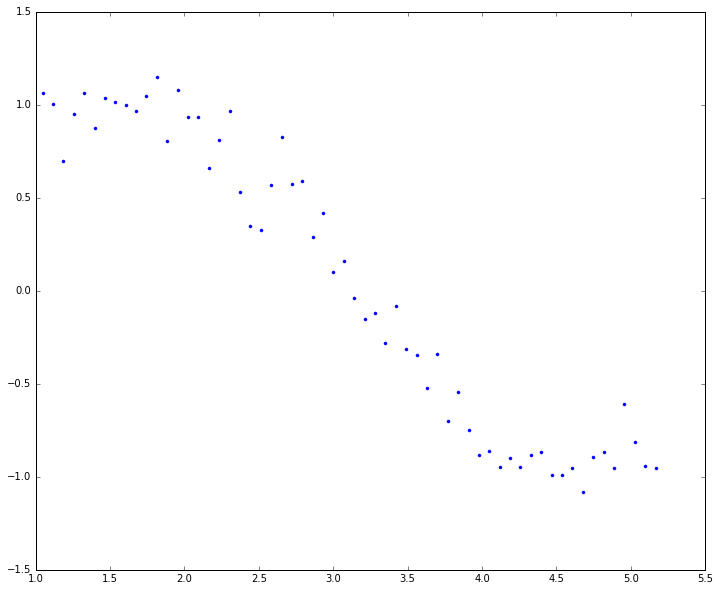

In [14]:
#Importing libraries. The same will be used throughout the article.
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

#Define input array with angles from 60deg to 300deg converted to radians
x = np.array([i*np.pi/180 for i in range(60,300,4)])
np.random.seed(10)  #Setting seed for reproducability
y = np.sin(x) + np.random.normal(0,0.15,len(x)) # Adding Noise
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
plt.plot(data['x'],data['y'],'.')

### First Thoughts: Polynomial Regression 
Features: $X^1, X^2, \dots, X^{15}$

In [15]:
for i in range(2,16):  #power of 1 is already there
    colname = 'x_%d'%i      #new var will be x_power
    data[colname] = data['x']**i
print data.head()

          x         y       x_2       x_3       x_4       x_5       x_6  \
0  1.047198  1.065763  1.096623  1.148381  1.202581  1.259340  1.318778   
1  1.117011  1.006086  1.247713  1.393709  1.556788  1.738948  1.942424   
2  1.186824  0.695374  1.408551  1.671702  1.984016  2.354677  2.794587   
3  1.256637  0.949799  1.579137  1.984402  2.493673  3.133642  3.937850   
4  1.326450  1.063496  1.759470  2.333850  3.095735  4.106339  5.446854   

        x_7       x_8        x_9       x_10       x_11       x_12       x_13  \
0  1.381021  1.446202   1.514459   1.585938   1.660790   1.739176   1.821260   
1  2.169709  2.423588   2.707173   3.023942   3.377775   3.773011   4.214494   
2  3.316683  3.936319   4.671717   5.544505   6.580351   7.809718   9.268760   
3  4.948448  6.218404   7.814277   9.819710  12.339811  15.506664  19.486248   
4  7.224981  9.583578  12.712139  16.862020  22.366630  29.668222  39.353420   

        x_14       x_15  
0   1.907219   1.997235  
1   4.707635   5

Let's consider building 15 models as follows:
* Model 1: Features - $X^1$
* Model 2: Features - $X, X^2$
* $\dots$
* Model 15: Features - $X, X^2, X^{15}$

In [16]:
#Import Linear Regression model from scikit-learn.
from sklearn.linear_model import LinearRegression
def linear_regression(data, power, models_to_plot):
    #initialize predictors:
    predictors=['x']
    if power>=2:
        predictors.extend(['x_%d'%i for i in range(2,power+1)])
    
    #Fit the model
    linreg = LinearRegression(normalize=True)
    linreg.fit(data[predictors],data['y'])
    y_pred = linreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered power
    if power in models_to_plot:
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for power: %d'%power)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

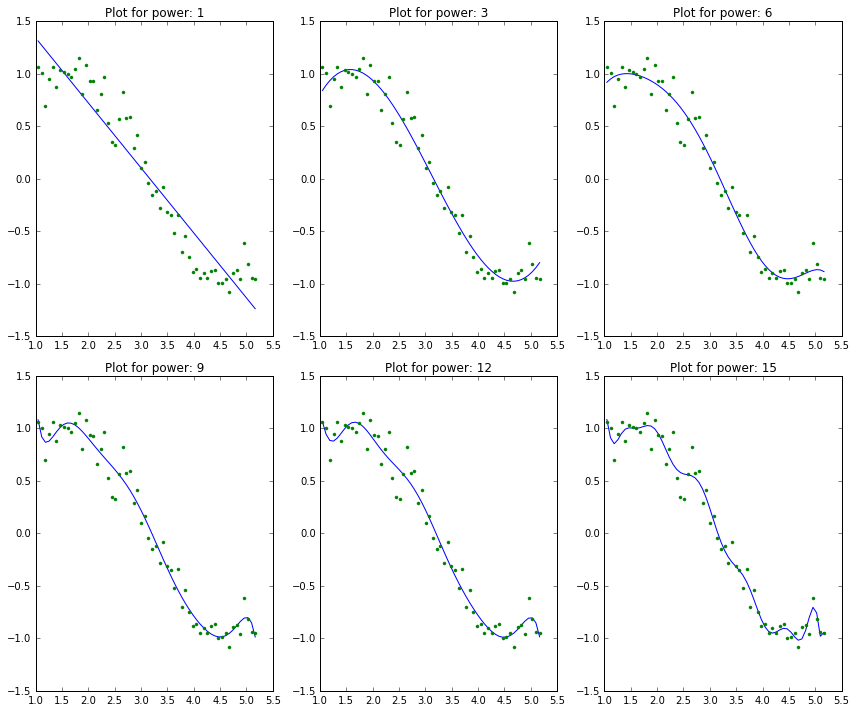

In [17]:
#Initialize a dataframe to store the results:
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['model_pow_%d'%i for i in range(1,16)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

#Define the powers for which a plot is required:
models_to_plot = {1:231,3:232,6:233,9:234,12:235,15:236}

#Iterate through all powers and assimilate results
for i in range(1,16):
    coef_matrix_simple.iloc[i-1,0:i+2] = linear_regression(data, power=i, models_to_plot=models_to_plot)

This clearly aligns with our initial understanding. As the model complexity increases, the models tends to fit even smaller deviations in the training data set. 

However, as we add more features, we expect ourselves to overfit!

In [18]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
model_pow_1,3.3,2,-0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_2,3.3,1.9,-0.58,-0.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_3,1.1,-1.1,3,-1.3,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_4,1.1,-0.27,1.7,-0.53,-0.036,0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_5,1,3,-5.1,4.7,-1.9,0.33,-0.021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_6,0.99,-2.8,9.5,-9.7,5.2,-1.6,0.23,-0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_7,0.93,19,-56,69,-45,17,-3.5,0.4,-0.019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_8,0.92,43,-1.4e+02,1.8e+02,-1.3e+02,58,-15,2.4,-0.21,0.0077,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_9,0.87,1.7e+02,-6.1e+02,9.6e+02,-8.5e+02,4.6e+02,-1.6e+02,37,-5.2,0.42,-0.015,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_10,0.87,1.4e+02,-4.9e+02,7.3e+02,-6e+02,2.9e+02,-87,15,-0.81,-0.14,0.026,-0.0013,NaN,NaN,NaN,NaN,NaN


It is clearly evident that the size of coefficients increase exponentially with increase in model complexity

## Ridge Regression

In [21]:
from sklearn.linear_model import Ridge
def ridge_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(data[predictors],data['y'])
    y_pred = ridgereg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

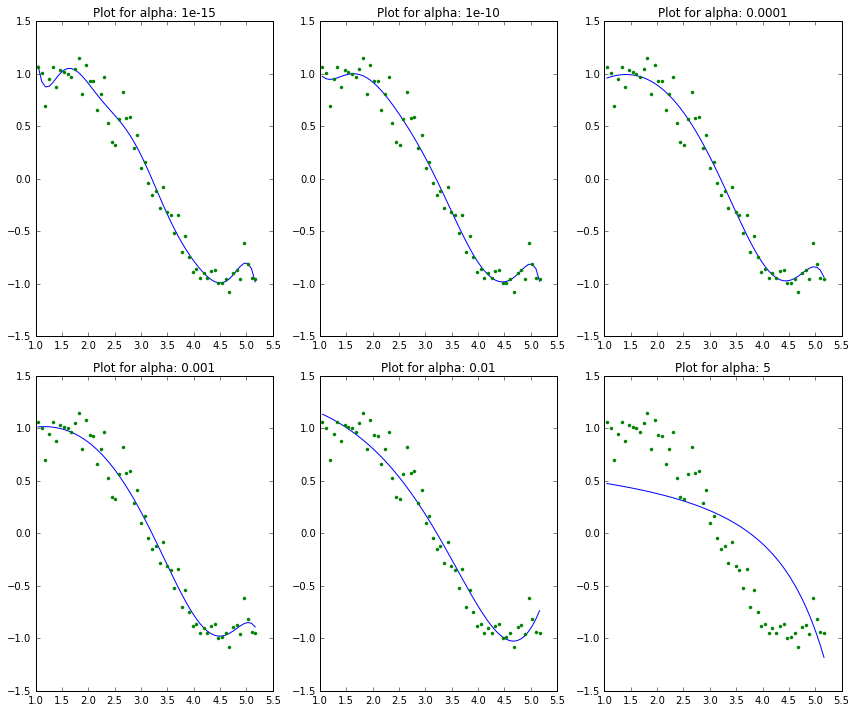

In [22]:
#Initialize predictors to be set of 15 powers of x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

#Set the different values of alpha to be tested
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

#Initialize the dataframe for storing coefficients.
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, 1e-2:235, 5:236}
for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(data, predictors, alpha_ridge[i], models_to_plot)

Here we can clearly observe that as the value of alpha increases, the model complexity reduces. Though higher values of alpha reduce overfitting, significantly high values can cause underfitting as well (eg. alpha = 5)

USE CROSS VALIDATION

In [23]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_ridge

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,0.87,95,-3e+02,3.8e+02,-2.4e+02,72,-2.7,-3.6,0.45,0.14,-0.019,-0.006,0.00086,0.00018,-4.3e-05,2.4e-06,-2.9e-09
alpha_1e-10,0.92,11,-29,31,-15,2.9,0.17,-0.091,-0.011,0.002,0.00064,2.4e-05,-2e-05,-4.2e-06,2.2e-07,2.3e-07,-2.3e-08
alpha_1e-08,0.95,1.3,-1.5,1.7,-0.68,0.039,0.016,0.00016,-0.00036,-5.4e-05,-2.9e-07,1.1e-06,1.9e-07,2e-08,3.9e-09,8.2e-10,-4.6e-10
alpha_0.0001,0.96,0.56,0.55,-0.13,-0.026,-0.0028,-0.00011,4.1e-05,1.5e-05,3.7e-06,7.4e-07,1.3e-07,1.9e-08,1.9e-09,-1.3e-10,-1.5e-10,-6.2e-11
alpha_0.001,1,0.82,0.31,-0.087,-0.02,-0.0028,-0.00022,1.8e-05,1.2e-05,3.4e-06,7.3e-07,1.3e-07,1.9e-08,1.7e-09,-1.5e-10,-1.4e-10,-5.2e-11
alpha_0.01,1.4,1.3,-0.088,-0.052,-0.01,-0.0014,-0.00013,7.2e-07,4.1e-06,1.3e-06,3e-07,5.6e-08,9e-09,1.1e-09,4.3e-11,-3.1e-11,-1.5e-11
alpha_1,5.6,0.97,-0.14,-0.019,-0.003,-0.00047,-7e-05,-9.9e-06,-1.3e-06,-1.4e-07,-9.3e-09,1.3e-09,7.8e-10,2.4e-10,6.2e-11,1.4e-11,3.2e-12
alpha_5,14,0.55,-0.059,-0.0085,-0.0014,-0.00024,-4.1e-05,-6.9e-06,-1.1e-06,-1.9e-07,-3.1e-08,-5.1e-09,-8.2e-10,-1.3e-10,-2e-11,-3e-12,-4.2e-13
alpha_10,18,0.4,-0.037,-0.0055,-0.00095,-0.00017,-3e-05,-5.2e-06,-9.2e-07,-1.6e-07,-2.9e-08,-5.1e-09,-9.1e-10,-1.6e-10,-2.9e-11,-5.1e-12,-9.1e-13
alpha_20,23,0.28,-0.022,-0.0034,-0.0006,-0.00011,-2e-05,-3.6e-06,-6.6e-07,-1.2e-07,-2.2e-08,-4e-09,-7.5e-10,-1.4e-10,-2.5e-11,-4.7e-12,-8.7e-13


In [24]:
coef_matrix_ridge.apply(lambda x: sum(x.values==0),axis=1)

alpha_1e-15     0
alpha_1e-10     0
alpha_1e-08     0
alpha_0.0001    0
alpha_0.001     0
alpha_0.01      0
alpha_1         0
alpha_5         0
alpha_10        0
alpha_20        0
dtype: int64

We note that none of the coefficients are 0!

## Lasso Regression

In [25]:
from sklearn.linear_model import Lasso
def lasso_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5)
    lassoreg.fit(data[predictors],data['y'])
    y_pred = lassoreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

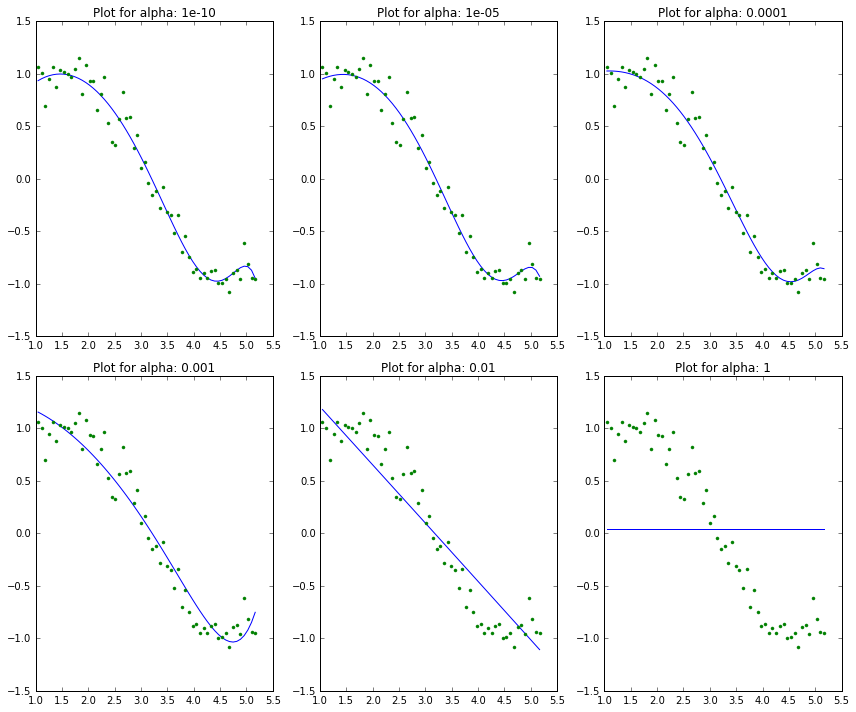

In [26]:
#Initialize predictors to all 15 powers of x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

#Define the alpha values to test
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

#Initialize the dataframe to store coefficients
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_lasso[i] for i in range(0,10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

#Define the models to plot
models_to_plot = {1e-10:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 1:236}

#Iterate over the 10 alpha values:
for i in range(10):
    coef_matrix_lasso.iloc[i,] = lasso_regression(data, predictors, alpha_lasso[i], models_to_plot)

In [29]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_lasso

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,0.96,0.22,1.1,-0.37,0.00089,0.0016,-0.00012,-6.4e-05,-6.3e-06,1.4e-06,7.8e-07,2.1e-07,4e-08,5.4e-09,1.8e-10,-2e-10,-9.2e-11
alpha_1e-10,0.96,0.22,1.1,-0.37,0.00088,0.0016,-0.00012,-6.4e-05,-6.3e-06,1.4e-06,7.8e-07,2.1e-07,4e-08,5.4e-09,1.8e-10,-2e-10,-9.2e-11
alpha_1e-08,0.96,0.22,1.1,-0.37,0.00077,0.0016,-0.00011,-6.4e-05,-6.3e-06,1.4e-06,7.8e-07,2.1e-07,4e-08,5.3e-09,2e-10,-1.9e-10,-9.3e-11
alpha_1e-05,0.96,0.5,0.6,-0.13,-0.038,-0,0,0,0,7.7e-06,1e-06,7.7e-08,0,0,0,-0,-7e-11
alpha_0.0001,1,0.9,0.17,-0,-0.048,-0,-0,0,0,9.5e-06,5.1e-07,0,0,0,-0,-0,-4.4e-11
alpha_0.001,1.7,1.3,-0,-0.13,-0,-0,-0,0,0,0,0,0,1.5e-08,7.5e-10,0,0,0
alpha_0.01,3.6,1.8,-0.55,-0.00056,-0,-0,-0,-0,-0,-0,-0,0,0,0,0,0,0
alpha_1,37,0.038,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_5,37,0.038,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_10,37,0.038,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0


In [27]:
coef_matrix_lasso.apply(lambda x: sum(x.values==0),axis=1)

alpha_1e-15      0
alpha_1e-10      0
alpha_1e-08      0
alpha_1e-05      8
alpha_0.0001    10
alpha_0.001     12
alpha_0.01      13
alpha_1         15
alpha_5         15
alpha_10        15
dtype: int64

We can see that as $\alpha$ increases, the number of coefficients being set to zero increases from 0 to 15. Implicitly, Lasso conducts feature selection as well!

- Lasso works the best with sparsity 

## Conclusion

* Key Differences:
    - Ridge: Typically includes all (or none) of the features in the model. 
        - Main advantage: Coefficient Shrinkage & Reducing Model Complexity
        - Prevents overfitting but does not reduce computational challenges
        - simple gradient descent is capable of the optimization
        - In the presence of highlt correlated features: works well but the coefficients will be distributed among them depending on correlation
    - Lasso: 
        - Main advantage: Performs coefficient shrinking as well as feature selection
        - Provides sparse solutions
        - requires subgradient optimization in gradient descent
        - In the presence of highly correlated features: arbitrailiy selects any one feature among the highly correlated ones and reduced the coefficients of the rest to zero.  The chosen variable changes randomly with change in model parameters. Does not work as well as compared to ridge regression.

* You can combine Lasso and Ridge Regression via Elastic Nets

## Ordinary Least Squares and Ridge Regression Variance

/usr/local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:465: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


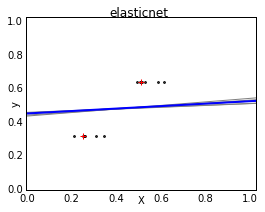

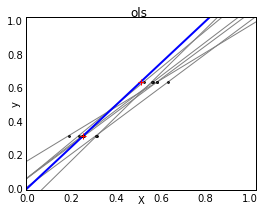

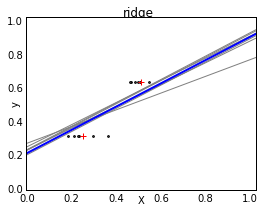

In [12]:
# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause


import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model

X_train = np.c_[.5, 1].T
y_train = [.5, 1]
X_test = np.c_[0, 2].T

np.random.seed(0)

classifiers = dict(ols=linear_model.LinearRegression(),
                   ridge=linear_model.Ridge(alpha=.1), 
                   elasticnet=linear_model.ElasticNet(l1_ratio=0.0))

fignum = 1
for name, clf in classifiers.items():
    fig = plt.figure(fignum, figsize=(4, 3))
    plt.clf()
    plt.title(name)
    ax = plt.axes([.12, .12, .8, .8])

    for _ in range(6):
        this_X = .1 * np.random.normal(size=(2, 1)) + X_train
        clf.fit(this_X, y_train)

        ax.plot(X_test, clf.predict(X_test), color='.5')
        ax.scatter(this_X, y_train, s=3, c='.5', marker='o', zorder=10)

    clf.fit(X_train, y_train)
    ax.plot(X_test, clf.predict(X_test), linewidth=2, color='blue')
    ax.scatter(X_train, y_train, s=30, c='r', marker='+', zorder=10)

    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_ylim((0, 1.6))
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.set_xlim(0, 2)
    fignum += 1

plt.show()

In [2]:
X_train = np.c_[.5, 1].T
y_train = [.5, 1]
X_test = np.c_[0, 2].T


In [3]:
X_train

array([[ 0.5],
       [ 1. ]])

In [4]:
y_train

[0.5, 1]

In [5]:
X_test

array([[0],
       [2]])

## Ridge Coefficients as a function of the regularization

In [ ]:
# Author: Fabian Pedregosa -- <fabian.pedregosa@inria.fr>
# License: BSD 3 clause

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

# X is the 10x10 Hilbert matrix
X = 1. / (np.arange(1, 11) + np.arange(0, 10)[:, np.newaxis])
y = np.ones(10)